In [1]:
%pylab inline

import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import time
import numpy as np

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
dat = pd.read_csv('tabl_04.csv', sep = ';')

In [3]:
data = dat.loc[1279]

### График исходного ряда

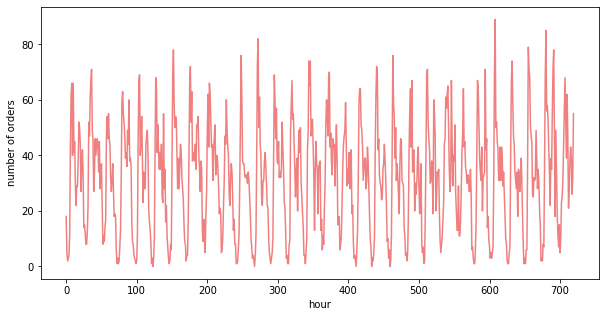

In [4]:
fig = plt.figure(figsize=(10,5))
plt.plot(list(range(720)), data, color = 'lightcoral')
plt.xlabel('hour')
plt.ylabel('number of orders')
plt.show()

In [5]:
data = pd.DataFrame(data)
data.columns = ['trip']

<Figure size 1080x720 with 0 Axes>

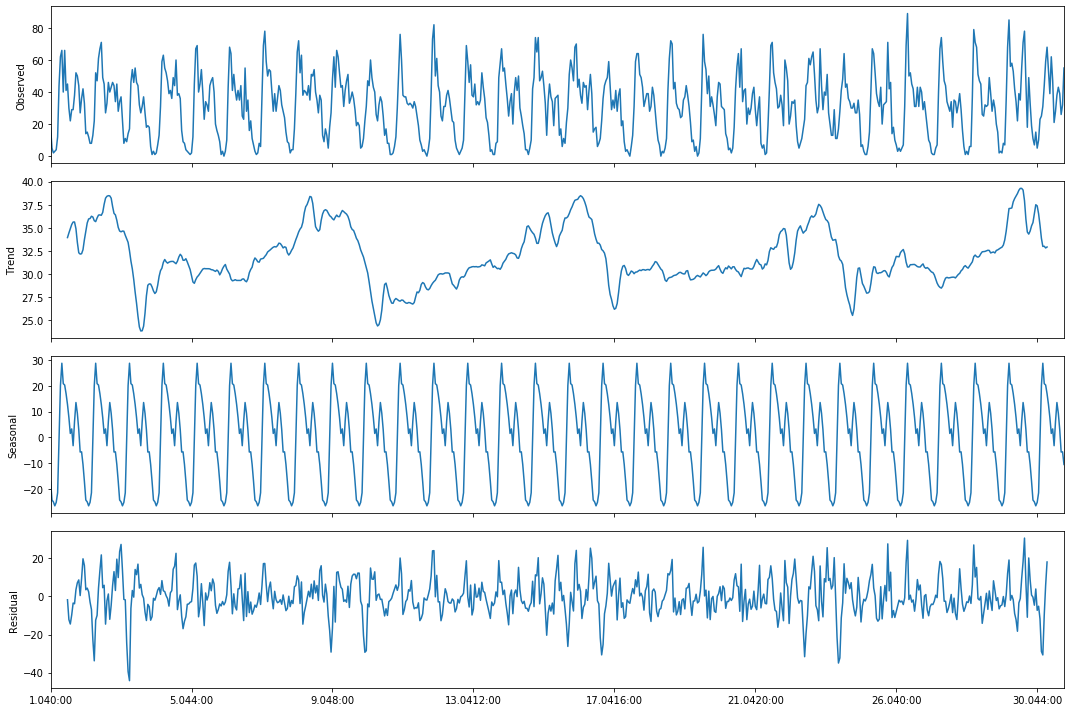

In [6]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data['trip'], freq = 24).plot()
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [8]:
mse_list = []
for number in range (1, 100):
    ols_data = data.copy()
    for i in range(1, number+1):        
        ols_data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
        ols_data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
    y = ols_data.trip
    X = ols_data.loc[:, 's_1':]
    try:
        model = LinearRegression()
        res = model.fit(X, y)
        mse_list.append(mean_squared_error(y, res.predict(X)))
    except LinAlgError:
        print('wrong parameters:', number)
        continue
    except ValueError:
        print('wrong :', number)
        continue
K_opt = np.argmin(mse_list)
print( 'Минимальное квадратичное отклонение достигнуто при K =', K_opt)

wrong : 1
wrong parameters: 67
Минимальное квадратичное отклонение достигнуто при K = 96


In [9]:
data

,trip
1.040:00,18.0
1.041:00,5.0
1.042:00,2.0
1.043:00,3.0
1.044:00,4.0
1.045:00,12.0
1.046:00,44.0
1.047:00,62.0
1.048:00,66.0
1.049:00,40.0


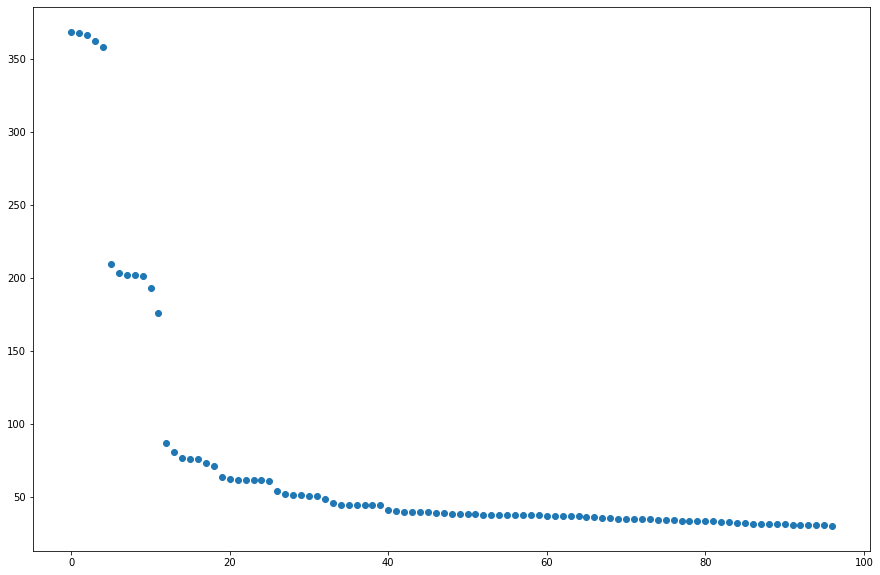

In [10]:
plt.plot(mse_list, 'o')

Возьмем К = 20, так как ошибка меняется не так сильно

In [11]:
K = 20
for i in range(1, K+1):        
    data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
    data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
y = data.trip
X = data.loc[:, 's_1':]
model = LinearRegression()
res = model.fit(X, y)
y_pred = res.predict(X)

In [12]:
data['l_prediction'] = y_pred
data['error'] = y - y_pred

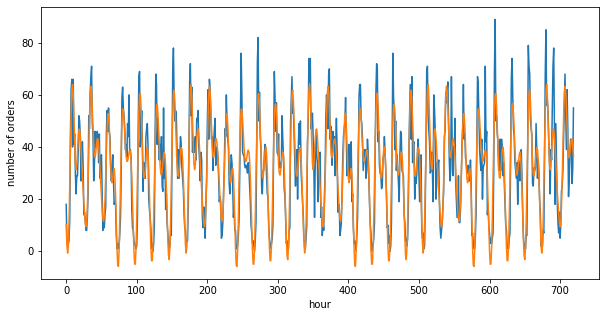

In [13]:
fig = plt.figure(figsize=(10,5))
plt.plot(list(range(720)), data.trip)
plt.plot(list(range(720)), data.l_prediction)
plt.xlabel('hour')
plt.ylabel('number of orders')
plt.show()

Полученная модель уже неплохо описывает данные

<Figure size 1080x720 with 0 Axes>

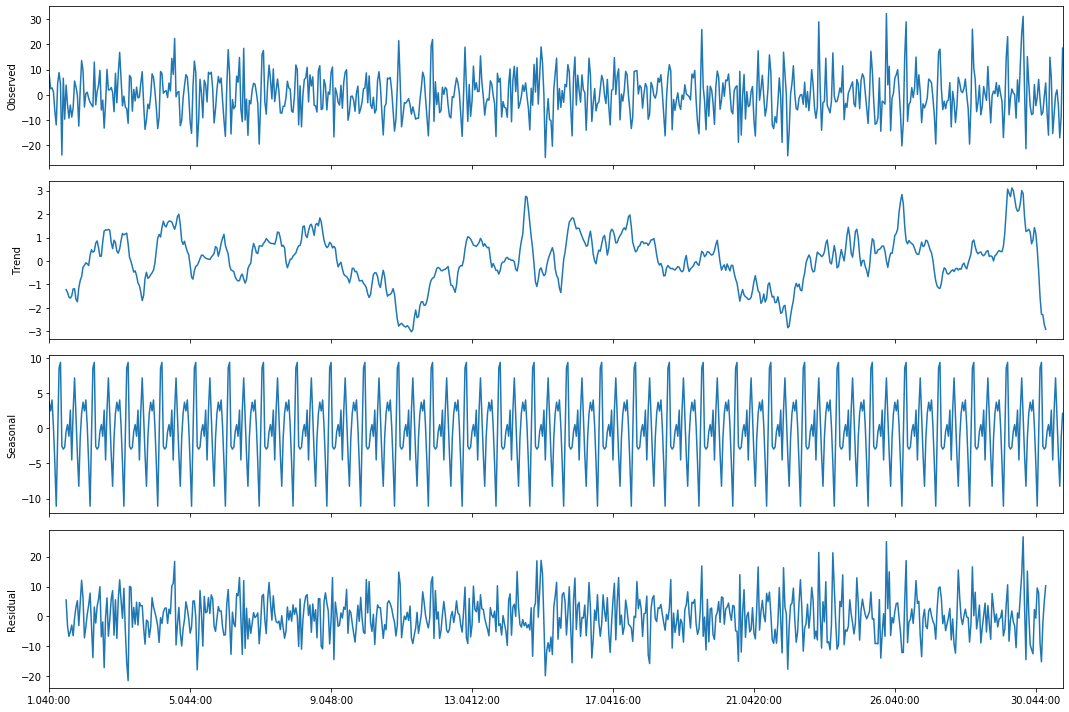

In [14]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data['error'], freq = 24).plot()
plt.show()

### Продифференцируем ряд

Критерий Дики-Фуллера: p= 2.703457271375018e-30


<Figure size 1080x720 with 0 Axes>

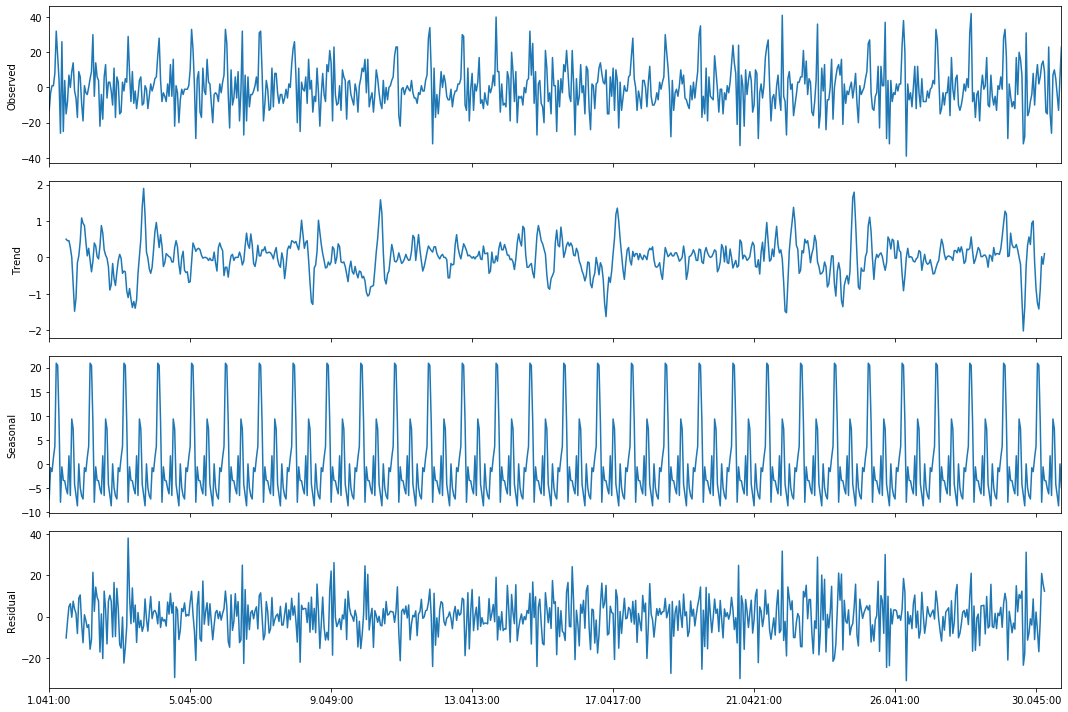

In [15]:
data['trips_diff'] = data.trip - data.trip.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.trips_diff[1:], freq = 24).plot()   
print("Критерий Дики-Фуллера: p=",  sm.tsa.stattools.adfuller(data.trips_diff[1:])[1])

### Недельное дифференцирование

Критерий Дики-Фуллера: p= 6.563165611665734e-19


<Figure size 1080x720 with 0 Axes>

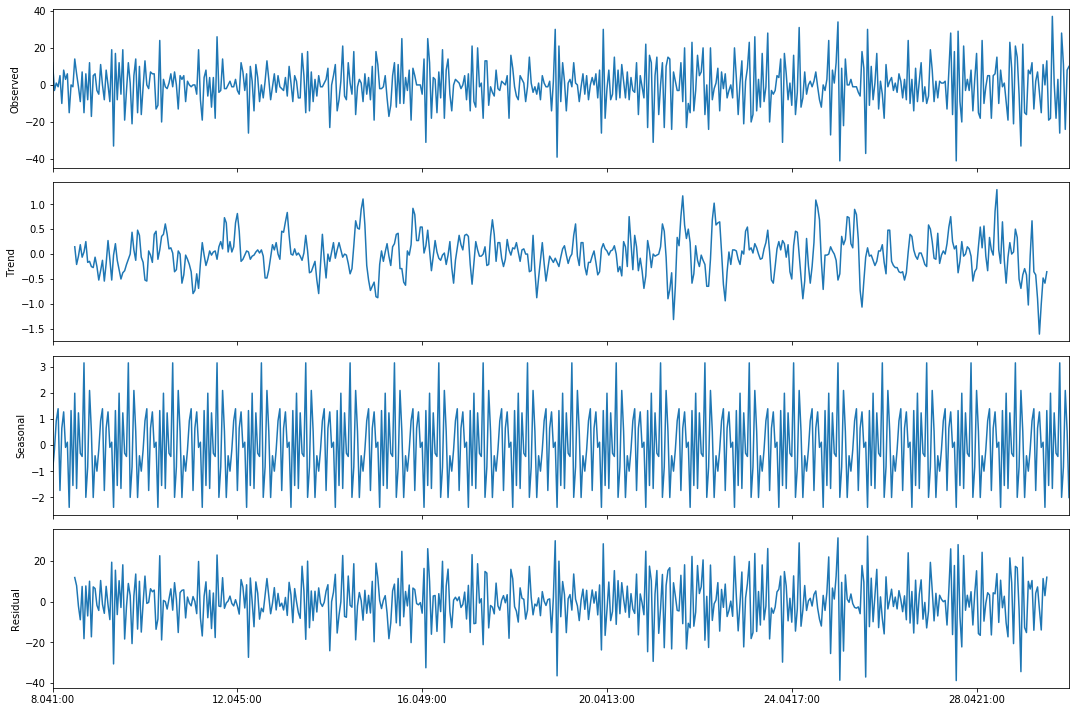

In [16]:
data['trips_diff1'] = data.trips_diff - data.trips_diff.shift(168)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.trips_diff1[169:], freq = 24).plot()
print("Критерий Дики-Фуллера: p=",  sm.tsa.stattools.adfuller(data.trips_diff1[169:])[1])

Применим только обычное дифференцирование, так как тогда это все займет вечность

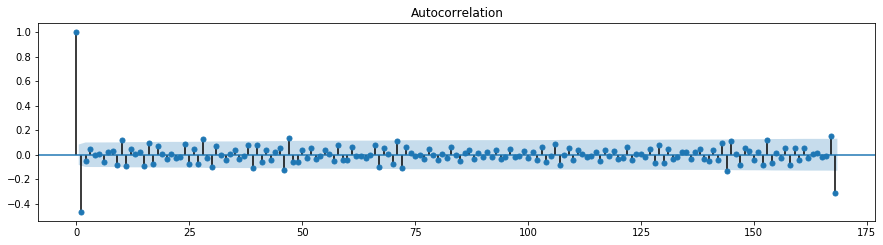

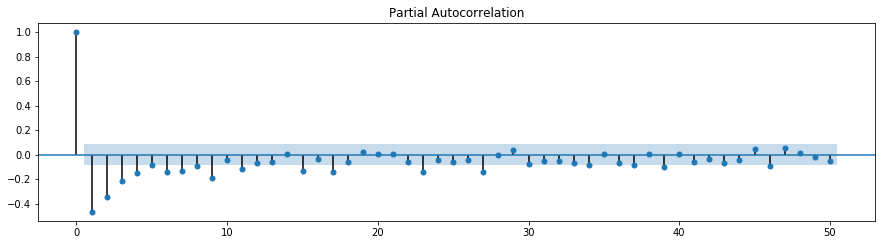

In [17]:
plt.figure(figsize = (15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['trips_diff1'][169:].values.squeeze(), lags=168, ax=ax)
pylab.show()
plt.figure(figsize = (15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['trips_diff1'][169:].values.squeeze(), lags=50, ax=ax)
pylab.show()

q = 2, Q = 1, p = 5, P = 1

In [18]:
q = range(1, 3)
p = range(1, 6)
P = range(0, 2)
Q = range(0, 2)
d = 1
D = 2

In [19]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

40

In [20]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.trip, exog = data[data.columns[1:2*K+1]], order=(param[0], 1, param[1]), 
                                        seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError :
        print('wrong:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

wrong: (3, 2, 1, 1)
Wall time: 35min 38s


In [21]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
19  (3, 1, 1, 1)  4979.531559
26  (4, 1, 1, 1)  4982.697737
30  (4, 2, 1, 1)  4982.776682
38  (5, 2, 1, 1)  4985.615322
34  (5, 1, 1, 1)  4985.954517


In [22]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               trip   No. Observations:                  720
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -2442.766
Date:                            Tue, 24 Nov 2020   AIC                           4979.532
Time:                                    20:05:14   BIC                           5194.691
Sample:                                         0   HQIC                          5062.600
                                            - 720                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s_1            2.1617      0.391      5.527      0.000       1.395       2.928
c_1            2.1020      0.430   

Критерий Стьюдента: p=0.699920
Критерий Дики-Фуллера: p=0.000000


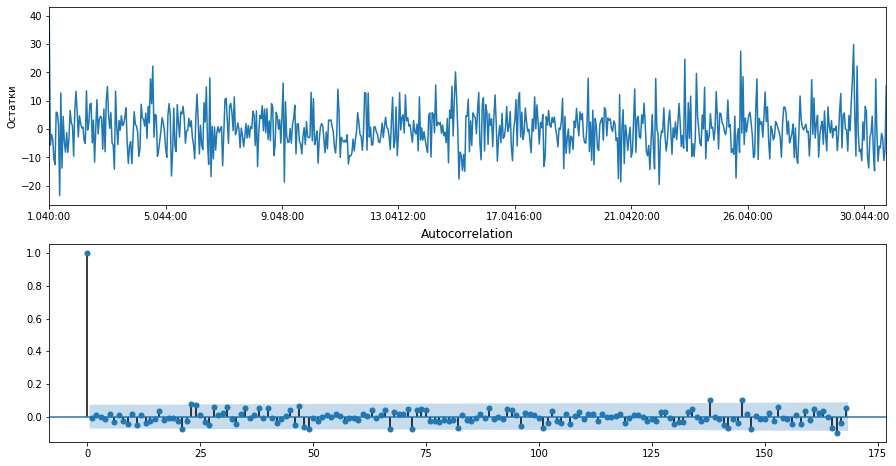

In [23]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Скорректируем смещенность модели с помощью средненего значения остатков.

In [24]:
mean_resid = np.abs(best_model.resid.values.mean())
print(mean_resid)

0.1060519631473037


Критерий Стьюдента: p=0.440863
Критерий Дики-Фуллера: p=0.000000


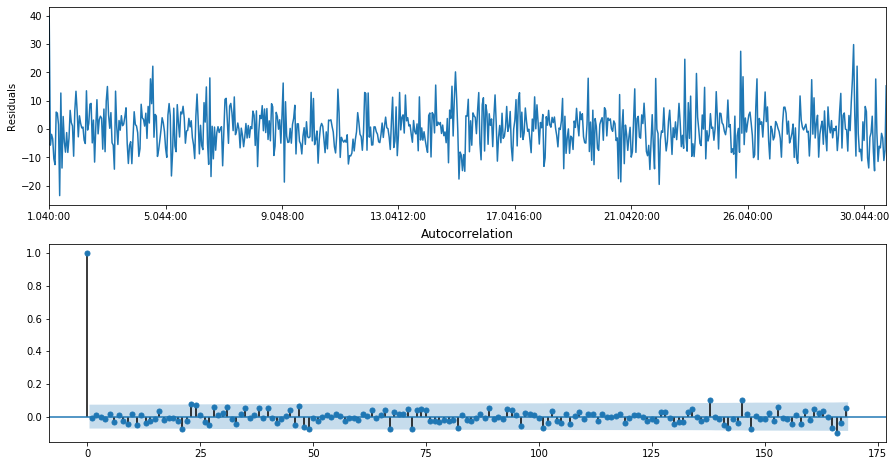

In [25]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze() + mean_resid , lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid + mean_resid , 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid + mean_resid)[1])

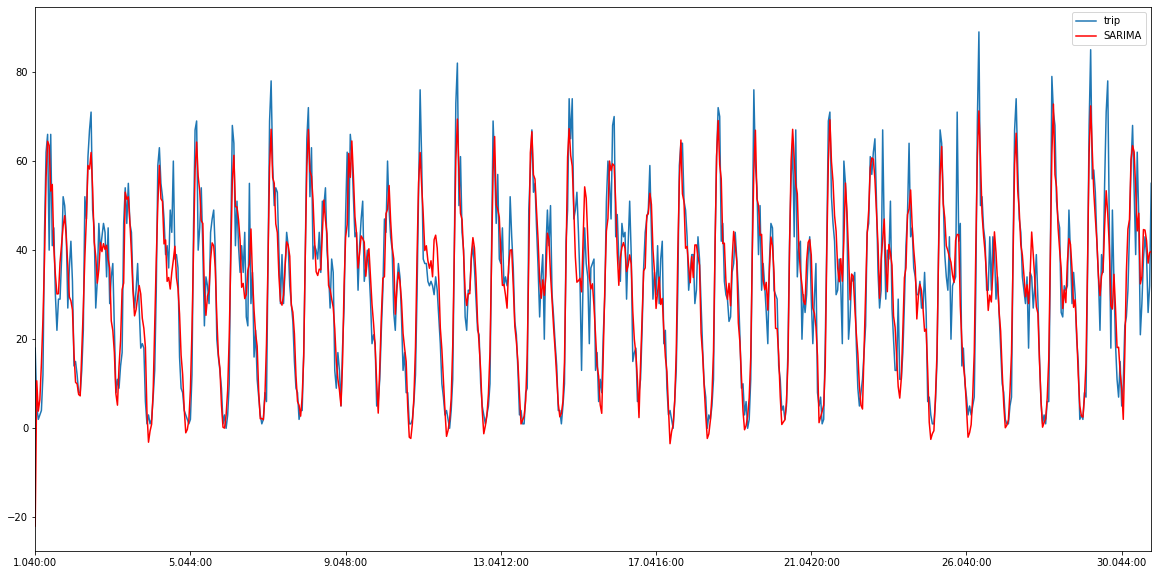

In [26]:
data['model'] = best_model.fittedvalues
plt.figure(figsize(20,10))
data.trip.plot(label = 'trip')
data.model.plot(color='r', label = 'SARIMA')
plt.legend()
pylab.show()

Полученная модель хорошо описывает данные